In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.datasets import load_iris, load_wine
import sklearn.metrics as metrics
import warnings
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import requests
from bs4 import BeautifulSoup

warnings.simplefilter('ignore')
plt.rcParams["figure.figsize"] = (12,8)
import matplotlib
matplotlib.rcParams["font.family"]="Malgun Gothic"
matplotlib.rcParams["axes.unicode_minus"]= False

import pandas as pd
import requests
import xmltodict
import time

날씨를 예측
최고 최저   다음날의 최고 최저 기온을 예측 

날씨데이터 통계값 3~4개의 문제를 만들어서 구할것


In [2]:
url = 'https://www.weather.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'
res = requests.get(url)
# BS를 통해 받아온 response.content 값.

bs = BeautifulSoup( res.content, 'html.parser')
# BS의 parser 를 통해 html tag를 handling 할 수 있도록 변경.

lists = []
# 받아올 데이터들을 담을 배열
for l in bs.findAll('location'):
    for d in l.findAll('data'):
        lists.append( {'도시':str(l.city.string), '날짜':str(d.tmef.string), 
                       '날씨':str(d.wf.string),'최고':int(d.tmx.string),'최저':int(d.tmn.string)})

df = pd.DataFrame(lists)  # 배열을 DataFrame  으로 변환
df

,도시,날짜,날씨,최고,최저
0,서울,2021-07-28 00:00,맑음,34,26
1,서울,2021-07-28 12:00,맑음,34,26
2,서울,2021-07-29 00:00,맑음,34,25
3,서울,2021-07-29 12:00,구름많음,34,25
4,서울,2021-07-30 00:00,구름많음,34,26
...,...,...,...,...,...
450,여주,2021-08-01 00:00,구름많음,31,24
451,여주,2021-08-01 12:00,구름많음,31,24
452,여주,2021-08-02 00:00,맑음,32,23
453,여주,2021-08-03 00:00,구름많음,32,23


In [3]:
# String 날짜 값을 DateTime64[ns]로 변환
df['날짜'] = pd.to_datetime(df['날짜'], format="%Y-%m-%d %H:%M")

In [4]:
df_copy = df[['도시','날짜','최고','최저']].copy()

In [5]:
df_copy['날짜']

0     2021-07-28 00:00:00
1     2021-07-28 12:00:00
2     2021-07-29 00:00:00
3     2021-07-29 12:00:00
4     2021-07-30 00:00:00
              ...        
450   2021-08-01 00:00:00
451   2021-08-01 12:00:00
452   2021-08-02 00:00:00
453   2021-08-03 00:00:00
454   2021-08-04 00:00:00
Name: 날짜, Length: 455, dtype: datetime64[ns]

In [6]:
df_copy['날짜'] = df_copy['날짜'] + pd.Timedelta(days= -1)   # 오늘 날짜 와 날짜차이가 하루 나도록 하여 복사본 생성
df_copy['날짜']

0     2021-07-27 00:00:00
1     2021-07-27 12:00:00
2     2021-07-28 00:00:00
3     2021-07-28 12:00:00
4     2021-07-29 00:00:00
              ...        
450   2021-07-31 00:00:00
451   2021-07-31 12:00:00
452   2021-08-01 00:00:00
453   2021-08-02 00:00:00
454   2021-08-03 00:00:00
Name: 날짜, Length: 455, dtype: datetime64[ns]

In [7]:
df_copy['날짜'] = pd.to_numeric(df_copy['날짜'])        # datetime64 값을 회귀모델이 인식하지 못하여 numeric 으로 바꾸어줌.
df_copy.rename(columns= {'최고' : '내일최고', '최저' : '내일최저'}, inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   도시      455 non-null    object
 1   날짜      455 non-null    int64 
 2   내일최고    455 non-null    int64 
 3   내일최저    455 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 14.3+ KB


In [8]:
df_copy['날짜']

0      1627344000000000000
1      1627387200000000000
2      1627430400000000000
3      1627473600000000000
4      1627516800000000000
              ...         
450    1627689600000000000
451    1627732800000000000
452    1627776000000000000
453    1627862400000000000
454    1627948800000000000
Name: 날짜, Length: 455, dtype: int64

In [9]:
df_copy

,도시,날짜,내일최고,내일최저
0,서울,1627344000000000000,34,26
1,서울,1627387200000000000,34,26
2,서울,1627430400000000000,34,25
3,서울,1627473600000000000,34,25
4,서울,1627516800000000000,34,26
...,...,...,...,...
450,여주,1627689600000000000,31,24
451,여주,1627732800000000000,31,24
452,여주,1627776000000000000,32,23
453,여주,1627862400000000000,32,23


In [10]:
df.query('도시 == "서울"')

,도시,날짜,날씨,최고,최저
0,서울,2021-07-28 00:00:00,맑음,34,26
1,서울,2021-07-28 12:00:00,맑음,34,26
2,서울,2021-07-29 00:00:00,맑음,34,25
3,서울,2021-07-29 12:00:00,구름많음,34,25
4,서울,2021-07-30 00:00:00,구름많음,34,26
5,서울,2021-07-30 12:00:00,구름많음,34,26
6,서울,2021-07-31 00:00:00,구름많음,35,26
7,서울,2021-07-31 12:00:00,흐림,35,26
8,서울,2021-08-01 00:00:00,구름많음,34,26
9,서울,2021-08-01 12:00:00,구름많음,34,26


In [11]:
 df['날짜'] = pd.to_numeric(df['날짜'])

In [12]:
df_pre = pd.merge(df, df_copy, how ='left', on = ['도시', '날짜'])   

In [13]:
df_pre = df_pre[df_pre['내일최고'].isna()].drop(['내일최고', '내일최저'],axis=1)
df_pre   # 나중에 테스트 시켜볼 오늘 데이터들.

,도시,날짜,날씨,최고,최저
9,서울,1627819200000000000,구름많음,34,26
12,서울,1628035200000000000,맑음,34,26
22,인천,1627819200000000000,구름많음,32,26
25,인천,1628035200000000000,맑음,32,26
35,수원,1627819200000000000,구름많음,34,25
...,...,...,...,...,...
428,용인,1628035200000000000,맑음,34,24
438,광주,1627819200000000000,구름많음,32,24
441,광주,1628035200000000000,맑음,34,24
451,여주,1627819200000000000,구름많음,31,24


In [14]:
# 오늘 날씨 + 내일 날씨 를 병합.
df_merge = pd.merge(df, df_copy, how = 'inner', on = ['도시', '날짜'])    

# 내일 날씨는 예측해야할 값이고, 실제 값이 들어있지 않으므로 해당 열은 탈락.
df_merge.info()  # 455 -> 385 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   도시      385 non-null    object
 1   날짜      385 non-null    int64 
 2   날씨      385 non-null    object
 3   최고      385 non-null    int64 
 4   최저      385 non-null    int64 
 5   내일최고    385 non-null    int64 
 6   내일최저    385 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 24.1+ KB


In [15]:
df_merge

,도시,날짜,날씨,최고,최저,내일최고,내일최저
0,서울,1627430400000000000,맑음,34,26,34,25
1,서울,1627473600000000000,맑음,34,26,34,25
2,서울,1627516800000000000,맑음,34,25,34,26
3,서울,1627560000000000000,구름많음,34,25,34,26
4,서울,1627603200000000000,구름많음,34,26,35,26
...,...,...,...,...,...,...,...
380,여주,1627689600000000000,구름많음,33,24,31,24
381,여주,1627732800000000000,흐림,33,24,31,24
382,여주,1627776000000000000,구름많음,31,24,32,23
383,여주,1627862400000000000,맑음,32,23,32,23


In [16]:
df_merge.corr()

,날짜,최고,최저,내일최고,내일최저
날짜,1.000000,-0.136871,0.234725,-0.007544,0.165883
최고,-0.136871,1.000000,0.258045,0.803236,0.310469
최저,0.234725,0.258045,1.000000,0.265768,0.867597
내일최고,-0.007544,0.803236,0.265768,1.000000,0.328224
내일최저,0.165883,0.310469,0.867597,0.328224,1.000000


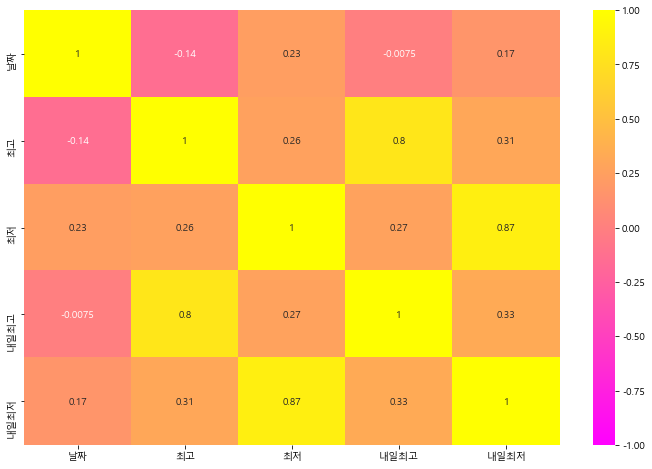

In [17]:
sns.heatmap(df_merge.corr(), cmap='spring',annot=True, vmin=-1, vmax=1)
plt.show()

In [18]:
# 도시와, 날씨가 string 이므로 Encoding을 수행
df_l = pd.get_dummies(df_merge, columns=['도시', '날씨'])
df_pre_l =  pd.get_dummies(df_pre, columns=['도시', '날씨'])
df_l

,날짜,최고,최저,내일최고,내일최저,도시_가평,도시_강화,도시_고양,도시_과천,도시_광명,...,도시_이천,도시_인천,도시_파주,도시_평택,도시_포천,도시_하남,도시_화성,날씨_구름많음,날씨_맑음,날씨_흐림
0,1627430400000000000,34,26,34,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1627473600000000000,34,26,34,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1627516800000000000,34,25,34,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1627560000000000000,34,25,34,26,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1627603200000000000,34,26,35,26,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1627689600000000000,33,24,31,24,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
381,1627732800000000000,33,24,31,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
382,1627776000000000000,31,24,32,23,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
383,1627862400000000000,32,23,32,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
x_data = df_l.drop(columns = ['내일최고', '내일최저'])  
x_data = x_data.drop(['도시_가평', '날씨_구름많음'], axis=1)# '도시', '날씨' 열의 VIF를 낮추기 위해 각 값의 마지막 값들을 삭제.
df_pre_l =  df_pre_l.drop(['도시_가평', '날씨_구름많음'], axis=1)
x_data

,날짜,최고,최저,도시_강화,도시_고양,도시_과천,도시_광명,도시_광주,도시_구리,도시_군포,...,도시_의정부,도시_이천,도시_인천,도시_파주,도시_평택,도시_포천,도시_하남,도시_화성,날씨_맑음,날씨_흐림
0,1627430400000000000,34,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1627473600000000000,34,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1627516800000000000,34,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1627560000000000000,34,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1627603200000000000,34,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1627689600000000000,33,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
381,1627732800000000000,33,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
382,1627776000000000000,31,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
383,1627862400000000000,32,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
# '날씨_흐림' 이 없다 만들어주자.
for i in df_pre_l.index:
    df_pre_l['날씨_흐림'] = 0
df_pre_l

,날짜,최고,최저,도시_강화,도시_고양,도시_과천,도시_광명,도시_광주,도시_구리,도시_군포,...,도시_의정부,도시_이천,도시_인천,도시_파주,도시_평택,도시_포천,도시_하남,도시_화성,날씨_맑음,날씨_흐림
9,1627819200000000000,34,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1628035200000000000,34,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22,1627819200000000000,32,26,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
25,1628035200000000000,32,26,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
35,1627819200000000000,34,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,1628035200000000000,34,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
438,1627819200000000000,32,24,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
441,1628035200000000000,34,24,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
451,1627819200000000000,31,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y_data = df_l[['내일최고','내일최저']]
y_data

,내일최고,내일최저
0,34,25
1,34,25
2,34,26
3,34,26
4,35,26
...,...,...
380,31,24
381,31,24
382,32,23
383,32,23


In [22]:
# x_train, x_test, y_train, y_test = train_test_split(x_data,x_data,test_size=0.33, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [23]:
x_train

,날짜,최고,최저,도시_강화,도시_고양,도시_과천,도시_광명,도시_광주,도시_구리,도시_군포,...,도시_의정부,도시_이천,도시_인천,도시_파주,도시_평택,도시_포천,도시_하남,도시_화성,날씨_맑음,날씨_흐림
298,1627473600000000000,33,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
70,1627603200000000000,29,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,1627732800000000000,33,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
280,1627646400000000000,34,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,1627689600000000000,33,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1627689600000000000,33,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,1627948800000000000,34,24,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,1627862400000000000,28,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
86,1627862400000000000,33,24,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
model_lr = make_pipeline(StandardScaler(), LinearRegression() )
model_lr.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [25]:
model_lr.score(x_train, y_train)

0.835677163922028

In [26]:
model_lr.score(x_test, y_test)

0.7570545207242276

In [33]:
# 예측값
print('최고', '최저')
print(model_lr.predict(df_pre_l))

최고	 최저
[[34.20833421 25.9130318 ]
 [34.31235616 25.74422623]
 [32.31317227 26.14630564]
 [32.41719422 25.97750008]
 [34.3958634  25.14630657]
 [34.5520022  25.00235868]
 [34.3789441  24.32501121]
 [34.48296605 24.15620564]
 [34.34856185 24.65243753]
 [34.61341184 24.24320461]
 [33.89577302 25.0019442 ]
 [33.99979497 24.83313863]
 [28.54481594 23.2237918 ]
 [28.48800985 23.29541359]
 [33.48278058 24.13632504]
 [33.63891938 23.99237715]
 [34.03918688 25.91912503]
 [34.40827055 25.55960746]
 [31.88609944 23.48469284]
 [31.77717651 23.53145695]
 [32.61256783 25.15610678]
 [32.71658978 24.98730122]
 [33.51969446 24.76990496]
 [33.78454446 24.36067204]
 [34.22772822 24.99598568]
 [34.33175017 24.82718012]
 [33.18712641 24.77265657]
 [33.29114836 24.60385101]
 [32.85621229 24.03939224]
 [33.01235108 23.89544435]
 [33.3419545  24.3919198 ]
 [33.71103818 24.03240224]
 [32.5316484  23.78598721]
 [32.6877872  23.64203932]
 [33.01226197 23.776419  ]
 [33.32922881 23.39204376]
 [33.26781256 22.6800

2. 도시별 날씨 평균

In [ ]:
# df.groupby('도시', sort=False).mean()

In [28]:
c_max = pd.DataFrame(df.groupby('도시')['최고'].mean())
c_min = pd.DataFrame(df.groupby('도시')['최저'].mean())

In [29]:
df_c = pd.merge(c_min, c_max, left_index=True,  right_index=True)
df_c

,최저,최고
도시,,
가평,22.384615,33.461538
강화,23.615385,31.846154
고양,24.000000,33.615385
과천,24.000000,33.538462
광명,25.846154,34.153846
광주,23.538462,32.769231
구리,25.076923,33.769231
군포,24.923077,34.153846
김포,25.000000,32.615385


3. 도시별 최고,최저 기온간 차이

In [30]:
df_c['최대차이'] = df_c['최고'] - df_c['최저']
df_c.sort_values('최대차이', ascending=False)

,최저,최고,최대차이
도시,,,
연천,22.153846,33.230769,11.076923
가평,22.384615,33.461538,11.076923
이천,24.153846,34.307692,10.153846
파주,24.000000,34.076923,10.076923
의왕,23.461538,33.307692,9.846154
오산,24.076923,33.923077,9.846154
고양,24.000000,33.615385,9.615385
동두천,23.461538,33.000000,9.538462
과천,24.000000,33.538462,9.538462


4.날씨 데이터중 일교차가 가장 큰 순서

In [31]:
df['일교차'] = df['최고'] - df['최저']
df['날짜'] = pd.to_datetime(df['날짜'])
df.sort_values('일교차', ascending=False)

,도시,날짜,날씨,최고,최저,일교차
260,가평,2021-07-28 00:00:00,맑음,35,21,14
261,가평,2021-07-28 12:00:00,맑음,35,21,14
237,연천,2021-07-29 12:00:00,구름많음,34,21,13
236,연천,2021-07-29 00:00:00,맑음,34,21,13
262,가평,2021-07-29 00:00:00,맑음,34,22,12
...,...,...,...,...,...,...
86,백령도,2021-08-01 00:00:00,구름많음,28,23,5
87,백령도,2021-08-01 12:00:00,구름많음,28,23,5
89,백령도,2021-08-03 00:00:00,구름많음,28,23,5
90,백령도,2021-08-04 00:00:00,맑음,29,24,5
